## Brief Description
This notebook contains code for our third and current approach.
We added more data by including all group members and variations in signals to handle overfitting.
Results were great when tested on ourselves, but could be improved upon when ran with the test set.

# Preprocess and Load Data

In [1]:
from ADUtils import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

## Load Data

In [2]:
# Whether you already have data stored in a npy file
load_from_npy = False

In [3]:
label_map = {label:num for num, label in enumerate(actions)}

In [51]:
# This loads data if it is not already stored in a npy file. 
if not load_from_npy:

    sequences, labels = [], []
    skip_sequence = False
    for action in actions:
        action_path = os.path.join(DATA_PATH, action)
        if not os.path.exists(action_path):
            continue
        for sequence in np.array(os.listdir(action_path)).astype(int):
            window = []
            skip_sequence = False
            for frame_num in range(sequence_length):
                sequence_path = os.path.join(action_path, str(sequence))
                # 1. make sure path exists
                if not os.path.exists(sequence_path):
                    print("1")
                    skip_sequence = True
                    break
                # 2. make sure none are empty
                try:
                    res = np.load(os.path.join(sequence_path, "{}.npy".format(frame_num)))
                    window.append(res)
                except:
                    print(f"Cannot read {sequence_path} number {frame_num}")
                    print("2")
                    skip_sequence = True
                    break
            if not skip_sequence:
                # 3. make sure there is at least 30 frames
                if len(window) == 30:
                    sequences.append(window)
                    labels.append(label_map[action])
                    continue
                print("3")

## Description of Input Data

The tuple from the next command shows the dimension of our data. The details of the data is as follows. 

The first tuple displays the number of samples we collected. We collected samples for seven actions: 'raise_hand', 'thumbs_up', 'thumbs_down', 'cheer', 'cross_arms', 'clap', 'neutral'. For each of these actions, we captured variations of them to ensure we're covering variability for each action. This list describes the variation and number of samples for each:  
- raise_hand: 30 left hand only (15 hand on screen and 15 off), 30 right hand only (15 on screen and 15 off)
- thumbs_up: 30 left hand only, 30 right hand only, 30 both hands
- thumbs_down: 30 left hand only, 30 right hand only, 30 both hands 
- cheer: 30 hands below head, 30 hands above head 
- cross_arms: 30 no hands, 30 right hand only, 30 left hand only, 30 both hands
- clap: 30 right hand over left, 30 left hand over right, 30 both hands vertical to the screen
- neutral: 30 no hands 

The second element in the tuple shows that each sample has 30 frames. 

The last element in the tuple shows the number of data points per frame. These were extracted from the MediaPipe Holistic model. The features we are using include 33 pose landmarks (each of which have coordinates x, y, z, and visibility) and 21 hand landmarks (each have coordinates x, y, z). Moreover, we are collecing landmarks for both the left and the right hands. In total this is 258 coordinates (33 * 4 + 21 * 3 + 21 * 3). 

In [27]:
print(np.array(sequences).shape)
# number of samples, number of frames per sample, number of data points per frame

(270, 30, 258)


## Splitting Data

In [53]:
if not load_from_npy:
    X = np.array(sequences)
else:
    X = np.load('action_detect_X.npy')

In [54]:
if not load_from_npy:
    y = to_categorical(labels).astype(int)
else:
    y = np.load('action_detect_y.npy')

In [9]:
if load_from_npy:
    austin_X = np.load('austin_X.npy')
    jessica_X = np.load('jessica_X.npy')
    X = np.concatenate((X, austin_x, jessica_X))

    austin_y = np.load('austin_y.npy')
    jessica_y = np.load('jessica_y.npy')
    y = np.concatenate((y, to_categorical(austin_y).astype(int), to_categorical(jessica_y).astype(int)))

(270, 30, 258)

In [ ]:
save_to_numpy = False
if save_to_numpy and not load_from_numpy:
    np.save('action_detect_X.npy', X)
    np.save('action_detect_y.npy', y)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

# Build and Train Model

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard

In [62]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)
# might remove

## Chosen Architecture

We used multiple LSTM layers stacked together to allow the model to learn higher-level temporal representations. Each layer potentially captures different aspects of temporal dependencies in the data. The ReLU activation function in the dense layers introduces non-linearity into the model, allowing it to learn more complex patterns in the data. The final dense layer uses a softmax activation for classification. We found that this amount of layers allowed the model to learn complex relationships in the data without overfitting. 

In [63]:
model = Sequential()
# model.add(Input(shape=(30,258)))
model.add(Input(shape=X_train.shape[-2:]))
model.add(LSTM(64, return_sequences=True, activation='relu'))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [64]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [65]:
model.fit(X_train, y_train, epochs=100, callbacks=[tb_callback])

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2889 - loss: 1.7794
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4204 - loss: 1.4484
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4470 - loss: 1.3519
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5940 - loss: 0.9704
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7671 - loss: 0.6046
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8083 - loss: 0.5165
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8509 - loss: 0.4124
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7951 - loss: 0.5318
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7690 - loss: 0.7337
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6676 - loss: 0.8225
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8543 - loss: 0.4725
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9728 - loss: 0.0899
Epoch 69/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9922 - loss: 0.0313
Epoch 70/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9916 - loss: 0.0308
Epoch 71/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9460 - loss: 0.1505
Epoch 72/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9922 - loss: 0.0362
Epoch 73/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9923 - loss: 0.0322
Epoch 74/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9908 - loss: 0.0331
Epoch 75/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9952 - loss: 0.0186
Epoch 76/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9924 - loss: 0.0238
Epoch 77/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9960 - loss: 0.0191
Epoch 78/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9632 - loss: 0.1218
Epoch 79/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - a

In [66]:
save_model = False
if save_model:
    model.save('action.keras')

## Training with Monitoring to Find Number of Epochs

This section lets you see which number of epochs may be best for specified batch size. 

As shown by 5-cross-fold-validation, our initial implementation was good. We wanted to see if it could be further improved with different number of epochs and batches. 

In [102]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [103]:
# Callbacks for early stopping and saving the best model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=callbacks, verbose=1)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9978 - loss: 0.0135
Epoch 2/50
 9/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9946 - loss: 0.0187   

C:\Users\Chanson\anaconda3\lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
C:\Users\Chanson\anaconda3\lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9946 - loss: 0.0172
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9970 - loss: 0.0134
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9964 - loss: 0.0096
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9987 - loss: 0.0036
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9989 - loss: 0.0049
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9987 - loss: 0.0089
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9981 - loss: 0.0091
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9988 - loss: 0.0040
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9996 - loss: 0.0047
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9992 - loss: 0.0051
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9973 - loss: 0.0104
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9978 - 

# Statistics

In [105]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, classification_report, f1_score

In [106]:
y_prob = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [107]:
y_true = np.argmax(y_test, axis=1).tolist()
y_pred = np.argmax(y_prob, axis=1).tolist()

In [108]:
accuracy_score(y_true, y_pred)

0.9852216748768473

In [71]:
classification_report(y_true, y_pred)

'              precision    recall  f1-score   support\n\n           0       1.00      0.95      0.98        21\n           1       0.94      0.97      0.95        30\n           2       1.00      1.00      1.00        29\n           3       1.00      0.95      0.98        21\n           4       1.00      1.00      1.00        52\n           5       0.97      1.00      0.99        34\n           6       1.00      1.00      1.00        16\n\n    accuracy                           0.99       203\n   macro avg       0.99      0.98      0.98       203\nweighted avg       0.99      0.99      0.99       203\n'

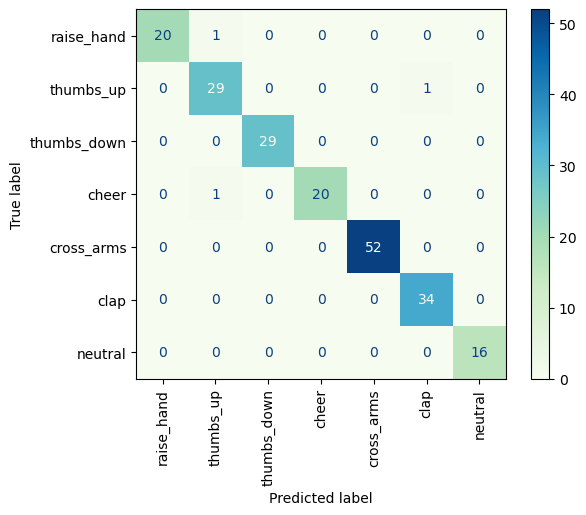

In [72]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt 
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=actions)
disp.plot(cmap='GnBu', xticks_rotation='vertical')
plt.show()

# Test in Real Time

In [16]:
from tensorflow.keras.models import load_model
if save_model:
    model = load_model('action.keras')

In [73]:
# change the colors
colors = [(245,117,16), (117,245,16), (16,117,245), (245,117,16), (117,245,16), (16,117,245), (245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [98]:
sequence = []
threshold = 0.5

# if you want to use video as testing
# video = '../data/test/questioning/cross_arms3.mp4'
# cap = cv2.VideoCapture(video)

# if you want a bigger video at the cost of performance
# cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
# cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
# cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        word = ''
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0), verbose=0)[0]
#             print(actions[np.argmax(res)])
            
            word = actions[np.argmax(res)]
                
            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
        
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)

        cv2.putText(image, word, (3,30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

# Self Label Video Testing

In [99]:
pred = ['clap', 'cross_arms', 'clap', 'thumbs_up', 'cross_arms', 'clap', 'thumbs_up', 'thumbs_up', 'cheer', 'thumbs_up', 'thumbs_up', 'cheer', 'thumbs_down', 'thumbs_down', 'clap', 'neutral', 'neutral', 'cross_arms', 'cross_arms', 'cross_arms']
act = ['clap', 'clap', 'clap', 'thumbs_up', 'thumbs_up', 'thumbs_up', 'raise_hand', 'raise_hand', 'raise_hand', 'cheer', 'cheer', 'cheer', 'thumbs_down', 'thumbs_down', 'thumbs_down', 'neutral', 'neutral', 'cross_arms', 'cross_arms', 'cross_arms']

accuracy_score(act, pred)

0.55

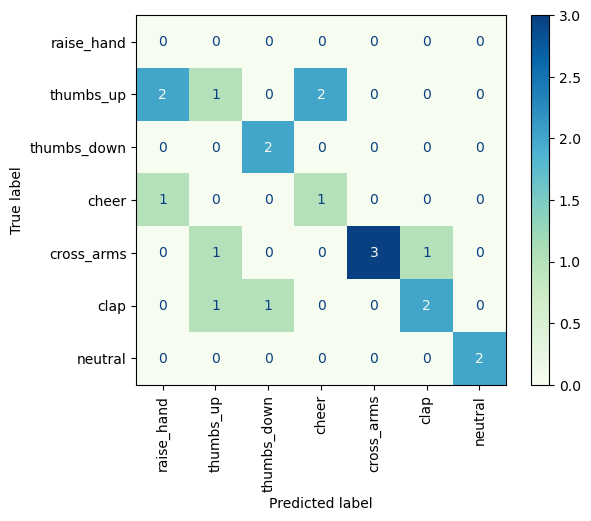

In [100]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt 

cm = confusion_matrix([label_map[item] for item in pred], [label_map[item] for item in act])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=actions)
disp.plot(cmap='GnBu', xticks_rotation='vertical')
plt.show()